In [1]:
!pip install kilonova-heating-rate
!pip install synphot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.7/913.7 KB 11.0 MB/s eta 0:00:00


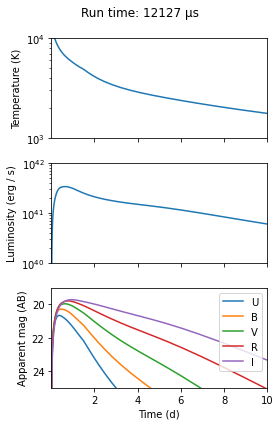

In [ ]:
#!/usr/bin/env python
import timeit

from astropy import constants as c
from astropy import units as u
from kilonova_heating_rate import lightcurve
from matplotlib import pyplot as plt
import numpy as np
import synphot

mass = 0.05 * u.Msun
velocities = np.asarray([0.1, 0.2, 0.4]) * c.c
opacities = np.asarray([3.0, 0.5]) * u.cm**2 / u.g
n = 4.5
t = np.geomspace(0.02, 10) * u.day

L, T, r = lightcurve(t, mass, velocities, opacities, n)

# Benchmark it
timing = int(np.round(1e6 * np.median(timeit.repeat(
    'lightcurve(t, mass, velocities, opacities, n)',
    globals=globals(), number=1, repeat=10))))

# Evaluate flux in band at 100 Mpc for a few different filters.
DL = 100 * u.Mpc
bandpass_labels = 'ubvri'
bandpasses = [
    synphot.SpectralElement.from_filter(f'johnson_{label}')
    for label in bandpass_labels]
seds = [
    synphot.SourceSpectrum(synphot.BlackBody1D, temperature=TT)
    * np.pi * (rr / DL).to(u.dimensionless_unscaled)**2
    for TT, rr in zip(T, r)]
abmags = [
    [synphot.Observation(sed, bandpass).effstim(u.ABmag).value for sed in seds]
    for bandpass in bandpasses]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(4, 6))
fig.suptitle(f'Run time: {timing} µs')
ax1.plot(t, T)
ax2.plot(t, L)
for label, abmag in zip(bandpass_labels, abmags):
    ax3.plot(t, abmag, label=label.upper())
ax3.set_xlabel(f'Time ({t.unit})')
ax1.set_ylabel(f'Temperature ({T.unit})')
ax2.set_ylabel(f'Luminosity ({L.unit})')
ax3.set_ylabel('Apparent mag (AB)')
ax1.set_xlim(0.01, 10)
ax1.set_ylim(1e3, 1e4)
ax2.set_ylim(1e40, 1e42)
ax3.set_ylim(19, 25)
ax3.invert_yaxis()
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.legend()
fig.tight_layout()
fig.savefig('example.png', dpi=300)